# **Phân tích cổ phiếu Visa(mã cổ phiếu:V)**

**Import các thư viện cần thiết**

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
!"{sys.executable}" -m pip install ta
from ta.momentum import RSIIndicator
from ta.trend import MACD

## 1.Lấy dữ liệu

Ta lấy dữ liệu từ yfinance

In [2]:
# Lấy dữ liệu 2 năm gần nhất
symbol = "V"
stock = yf.Ticker(symbol)
start_date = '2023-01-01'
end_date = '2025-06-14'

df = stock.history(start = start_date, end = end_date).reset_index()


In [3]:
df.drop(['Dividends', 'Stock Splits'], axis= 1, inplace= True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800
1,2023-01-04 00:00:00-05:00,205.702576,209.215674,205.702576,208.636703,6606200
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000
3,2023-01-06 00:00:00-05:00,210.000744,214.063375,209.107747,213.680664,6829700
4,2023-01-09 00:00:00-05:00,214.975988,218.057307,214.269443,214.514771,6294500


In [4]:
# Xuất dữ liệu gốc
df.to_csv("visa_raw.csv", index=False)

### Đồ thị biểu diễn giá cổ phiếu

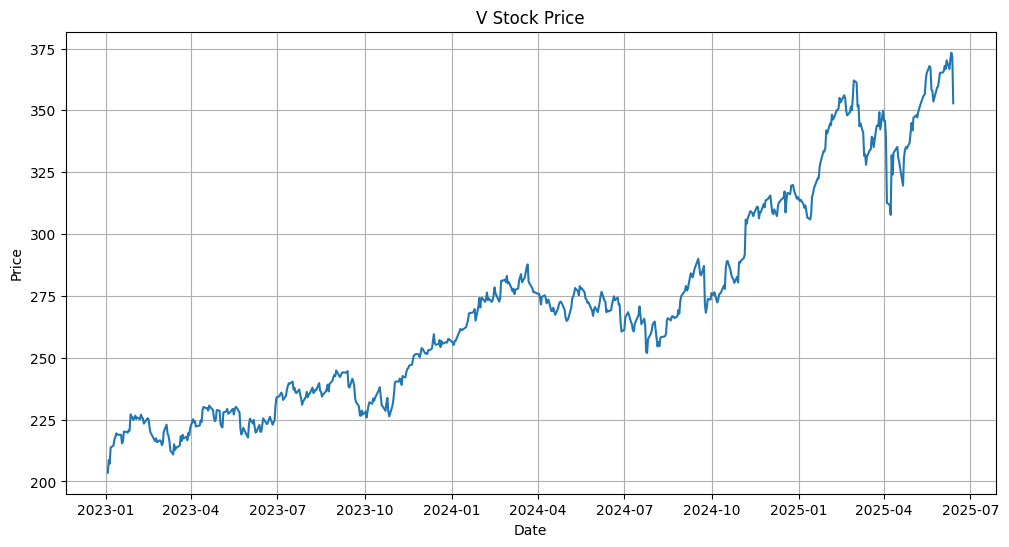

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Close')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 2. Làm sạch & Tiền xử lí

### 2.1. Drop missing value

Tuy thư viện yfinance đã loại bỏ những ngày không giao dịch vào những ngày lễ, nhưng ta vẫn cần kiểm tra để xem có ngày nào mà sàn không giao dịch hay không để tiến hành loại bỏ.

In [6]:
dt = df[df['Volume'] == 0]
dt

,Date,Open,High,Low,Close,Volume


Nhận thấy không còn ngày nào trong Data Frame có volume = 0,do đó không cần phải lọc. Sau đó ta sẽ xóa những ngày có NaN, tức là mising value ra khỏi Data Frame

In [7]:
df_clean = df.dropna().reset_index(drop= True)

### 2.2. Chuyển định dạng date time


Ta xóa những hàng bị trùng nhau và chuyển cột Date về đúng định dạng date time

In [8]:
# Đảm bảo Date đúng kiểu & drop duplicate theo date
df_clean.drop_duplicates(subset= 'Date')
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean.head()

,Date,Open,High,Low,Close,Volume
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800
1,2023-01-04 00:00:00-05:00,205.702576,209.215674,205.702576,208.636703,6606200
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000
3,2023-01-06 00:00:00-05:00,210.000744,214.063375,209.107747,213.680664,6829700
4,2023-01-09 00:00:00-05:00,214.975988,218.057307,214.269443,214.514771,6294500


### 2.3. Loại bỏ outliers

Vì đã loại bỏ hết tất cả những bất thường do yếu tố khách quan (sàn giao dịch, thời gian giao dịch), nên outliers (nếu có xuất hiện) chính là do các **giá trị lên xuống bất chợt do hoảng loạn** mà không phản ánh giá trị thực của cổ phiếu. Ta kiểm tra xem có giá trị nào không:

#### A, Z-score

- Với mỗi giá trị **x** trong chuỗi **Close**, **z_score = (x - m) / sigma**. Với m là trung bình, sigma là độ lệch chuẩn của toàn bộ **Close**.
- Z‑score cho biết “bao nhiêu độ lệch chuẩn” giá trị đó cách trung bình.
- Ưu điểm:
    - Dễ triển khai, tốc độ tính nhanh
    - Cho phép điều chỉnh ngưỡng linh hoạt (k)
- Nhược điểm:
    - Giả thiết dữ liệu phân phối chuẩn (normal)
    - Nhạy với outliers lớn (chính chúng kéo m, sigma lệch)


In [9]:
# TÍnh trung bình & độ lệch chuẩn của Close
m, sigma = df_clean['Close'].mean(), df_clean['Close'].std()

# Tính Z-score
df_clean['z_score'] = (df_clean['Close'] - m) / sigma

# Lọc
df_clean= df_clean[np.abs(df_clean['z_score']) <= 2].reset_index(drop= True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype                           
---  ------   --------------  -----                           
 0   Date     590 non-null    datetime64[ns, America/New_York]
 1   Open     590 non-null    float64                         
 2   High     590 non-null    float64                         
 3   Low      590 non-null    float64                         
 4   Close    590 non-null    float64                         
 5   Volume   590 non-null    int64                           
 6   z_score  590 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(1)
memory usage: 32.4 KB


#### B, IQR

- Nguyên lý:
    - Tính Q1 (25th percentile) và Q3 (75th percentile) của Close.
    - IQR = Q3 − Q1.
    - Outlier là những giá trị nằm ngoài: [Q1−1.5×IQR,Q3+1.5×IQR]

- Ưu:
    - Không phụ thuộc phân phối chuẩn của dữ liệu
    - Ít chịu ảnh hưởng bởi outliers cực đoan (robust)
- Nhược:
    - Ngưỡng “1.5 × IQR” là quy ước, có thể phải điều chỉnh
    - Không gợi ý mức độ “bao nhiêu σ” như Z‑score

In [10]:
# Tính Q1,Q3,IQR
Q1 = df_clean['Close'].quantile(0.25)
Q3 = df_clean['Close'].quantile(0.75)
IQR = Q3 - Q1

#Xác định ngưỡng
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Lọc
df_clean = df_clean[df_clean['Close'].between(lower_bound,upper_bound)]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype                           
---  ------   --------------  -----                           
 0   Date     590 non-null    datetime64[ns, America/New_York]
 1   Open     590 non-null    float64                         
 2   High     590 non-null    float64                         
 3   Low      590 non-null    float64                         
 4   Close    590 non-null    float64                         
 5   Volume   590 non-null    int64                           
 6   z_score  590 non-null    float64                         
dtypes: datetime64[ns, America/New_York](1), float64(5), int64(1)
memory usage: 32.4 KB


In [11]:
# Xuất dữ liệu sau khi làm sạch
new_df = df_clean.drop("z_score", axis= 'columns')
new_df.to_csv("visa_clean.csv", index=False)
new_df

,Date,Open,High,Low,Close,Volume
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800
1,2023-01-04 00:00:00-05:00,205.702576,209.215674,205.702576,208.636703,6606200
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000
3,2023-01-06 00:00:00-05:00,210.000744,214.063375,209.107747,213.680664,6829700
4,2023-01-09 00:00:00-05:00,214.975988,218.057307,214.269443,214.514771,6294500
...,...,...,...,...,...,...
585,2025-05-08 00:00:00-04:00,351.416362,354.740827,350.368115,350.687561,4156400
586,2025-05-09 00:00:00-04:00,351.246630,353.213365,350.088580,351.955475,3086600
587,2025-05-12 00:00:00-04:00,358.544564,361.290004,350.547834,355.260010,7985400
588,2025-05-23 00:00:00-04:00,353.750000,356.000000,352.220001,353.540009,5345900


## 3. Chỉ số kĩ thuật

### 3.1. SMA

- SMA ở ngày 𝑡 là trung bình cộng giá đóng cửa của n ngày gần nhất (bao gồm ngày 𝑡).

- Ví dụ SMA20 sẽ lấy trung bình 20 giá đóng cửa từ ngày t - 19 đến t.

In [12]:
df_clean['SMA20'] = df_clean['Close'].rolling(window= 20).mean()
df_clean['SMA50'] = df_clean['Close'].rolling(window= 50).mean()

df_clean.tail()

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50
585,2025-05-08 00:00:00-04:00,351.416362,354.740827,350.368115,350.687561,4156400,1.872238,337.376192,338.174368
586,2025-05-09 00:00:00-04:00,351.246630,353.213365,350.088580,351.955475,3086600,1.901992,338.770377,338.183353
587,2025-05-12 00:00:00-04:00,358.544564,361.290004,350.547834,355.260010,7985400,1.979540,339.891017,338.287581
588,2025-05-23 00:00:00-04:00,353.750000,356.000000,352.220001,353.540009,5345900,1.939176,340.836804,338.255377
589,2025-06-13 00:00:00-04:00,361.510010,363.010010,345.000000,352.850006,14181700,1.922984,341.716644,338.279457


### 3.2. EMA

EMA gán trọng số hàm mũ cho dữ liệu gần nhất, cho phản hồi nhanh hơn SMA.

In [13]:
df_clean['EMA20'] = df_clean['Close'].ewm(span= 20, min_periods= 20).mean()
df_clean.head(20)

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50,EMA20
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800,-1.581470,NaN,NaN,NaN
1,2023-01-04 00:00:00-05:00,205.702576,209.215674,205.702576,208.636703,6606200,-1.461261,NaN,NaN,NaN
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000,-1.495804,NaN,NaN,NaN
3,2023-01-06 00:00:00-05:00,210.000744,214.063375,209.107747,213.680664,6829700,-1.342895,NaN,NaN,NaN
4,2023-01-09 00:00:00-05:00,214.975988,218.057307,214.269443,214.514771,6294500,-1.323321,NaN,NaN,NaN
5,2023-01-10 00:00:00-05:00,214.897476,218.233930,214.102601,216.958221,10857000,-1.265981,NaN,NaN,NaN
6,2023-01-11 00:00:00-05:00,217.154496,218.027863,215.594214,217.949371,5408200,-1.242721,NaN,NaN,NaN
7,2023-01-12 00:00:00-05:00,217.949380,219.627415,216.487220,219.440964,4264400,-1.207718,NaN,NaN,NaN
8,2023-01-13 00:00:00-05:00,217.762916,219.578334,216.025990,218.891418,4283200,-1.220615,NaN,NaN,NaN
9,2023-01-17 00:00:00-05:00,218.224126,220.206365,218.214304,218.832535,6101100,-1.221996,NaN,NaN,NaN


Ta thấy ở 19 ngày đầu SMA20 và EMA 20 hiện NaN do chưa có đủ số ngày trước đó để tính toán, tương tự SMA50 cần phải đến ngày thứ 50 mới bắt đầu có dữ liệu.

### 3.3. RSI

RSI đo tỷ lệ giữa biến động tăng (gain) và biến động giảm (loss) trong n ngày.

In [14]:
rsi_indicator = RSIIndicator(close= df_clean['Close'], window= 14)
df_clean['RSI14'] = rsi_indicator.rsi()
print(df_clean[['Date', 'Close', 'RSI14']].head(15))

                        Date       Close      RSI14
0  2023-01-03 00:00:00-05:00  203.514252        NaN
1  2023-01-04 00:00:00-05:00  208.636703        NaN
2  2023-01-05 00:00:00-05:00  207.164734        NaN
3  2023-01-06 00:00:00-05:00  213.680664        NaN
4  2023-01-09 00:00:00-05:00  214.514771        NaN
5  2023-01-10 00:00:00-05:00  216.958221        NaN
6  2023-01-11 00:00:00-05:00  217.949371        NaN
7  2023-01-12 00:00:00-05:00  219.440964        NaN
8  2023-01-13 00:00:00-05:00  218.891418        NaN
9  2023-01-17 00:00:00-05:00  218.832535        NaN
10 2023-01-18 00:00:00-05:00  215.358673        NaN
11 2023-01-19 00:00:00-05:00  216.290939        NaN
12 2023-01-20 00:00:00-05:00  220.118088        NaN
13 2023-01-23 00:00:00-05:00  219.990463  76.395851
14 2023-01-24 00:00:00-05:00  219.705887  75.033302


### 3.4. Phương pháp phân tích kĩ thuật thêm: MACD

1. Tại sao chọn MACD?
- Kết hợp EMA ngắn và dài: MACD = EMA_fast (12) − EMA_slow (26).

- Crossover signal: Signal Line = EMA9 của MACD → khi MACD cắt lên cắt xuống Signal cho tín hiệu mua/bán.

- Histogram: phần chênh lệch giữa MACD và Signal giúp gauge momentum.
2. Nguyên lý 

-   Khi MACD cắt lên Signal → tín hiệu tăng (bullish cross)

- Khi MACD cắt xuống Signal → tín hiệu giảm (bearish cross)

- Histogram dương → momentum tăng; âm → momentum giảm

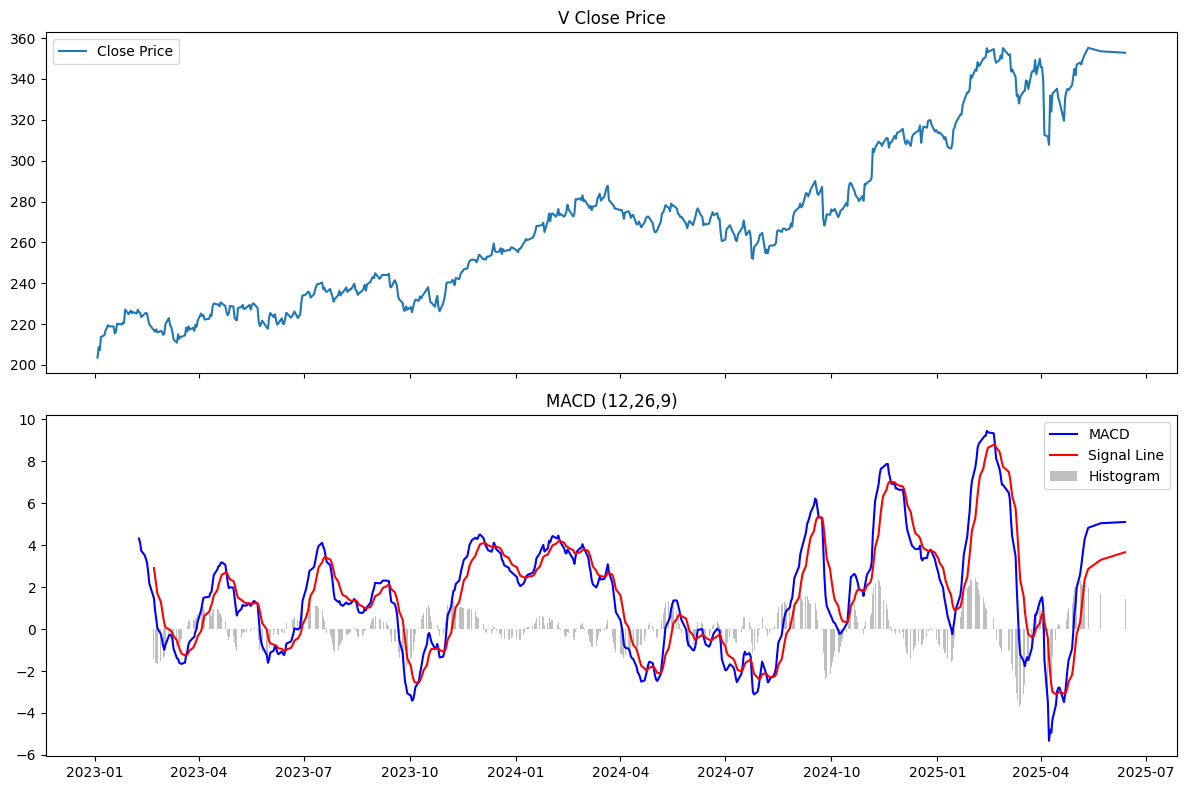

In [15]:
macd = MACD(close=df_clean['Close'], window_slow=26, window_fast=12, window_sign=9)
df_clean['MACD']        = macd.macd()
df_clean['MACD_signal'] = macd.macd_signal()
df_clean['MACD_hist']   = macd.macd_diff()

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# Giá đóng & MACD histogram
ax1.plot(df_clean['Date'], df_clean['Close'], label='Close Price')
ax1.set_title(f'{symbol} Close Price')
ax1.legend()

# MACD & Signal
ax2.plot(df_clean['Date'], df_clean['MACD'],       label='MACD',        color='blue')
ax2.plot(df_clean['Date'], df_clean['MACD_signal'],label='Signal Line', color='red')
ax2.bar(df_clean['Date'], df_clean['MACD_hist'],   label='Histogram',   color='grey', alpha=0.5)
ax2.set_title('MACD (12,26,9)')
ax2.legend()

plt.tight_layout()
plt.show()

### **Biểu đồ Kết hợp giữa giá đóng và các chỉ số**

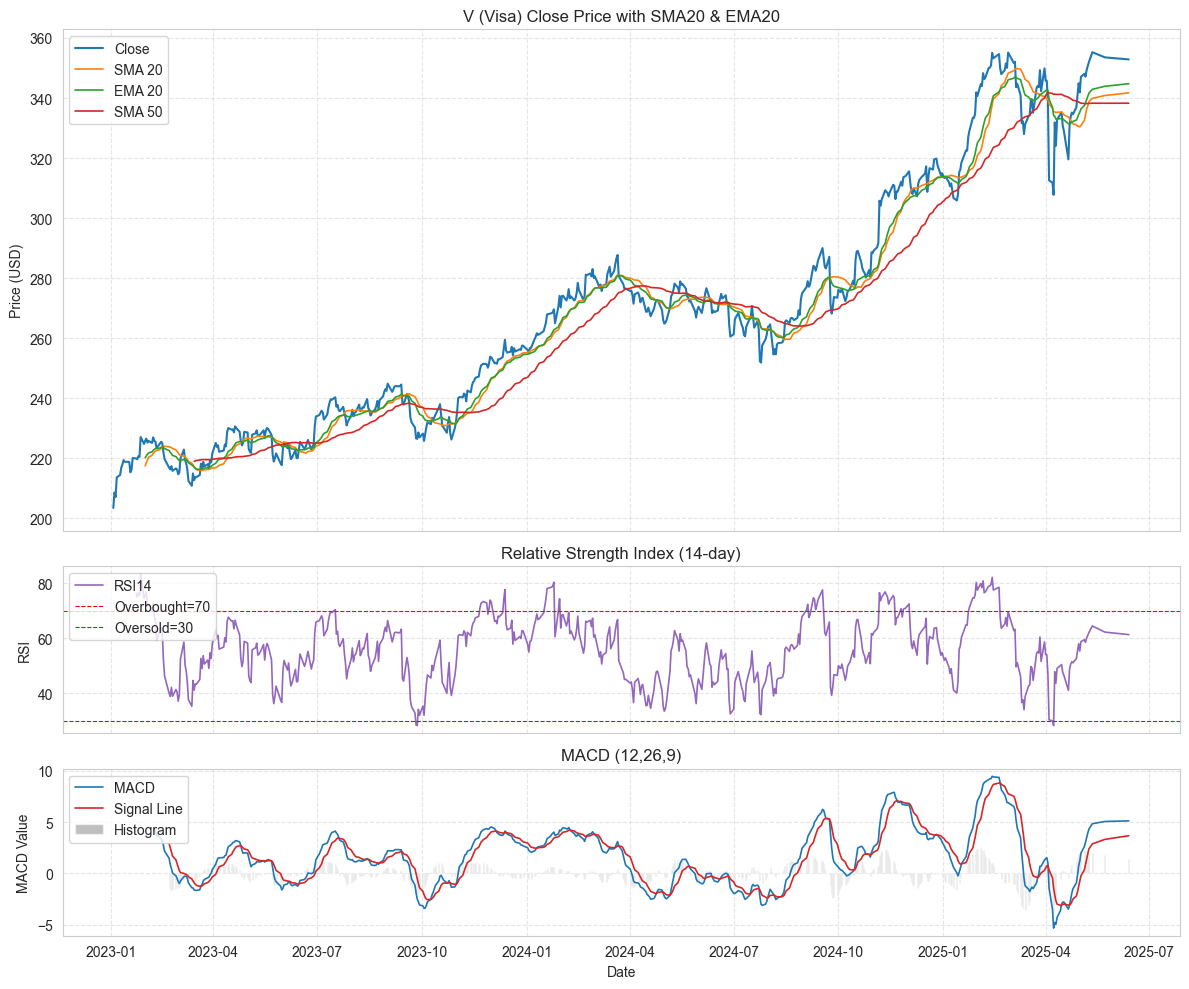

In [16]:
sns.set_style('whitegrid')

# Tạo figure với 3 subplots (chia theo tỷ lệ chiều cao)
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1,
    figsize=(12, 10),
    gridspec_kw={'height_ratios': [3, 1, 1]},
    sharex=True
)

# ---- Panel 1: Price + SMA20 + EMA20 + SMA50 ----
ax1.plot(df_clean['Date'], df_clean['Close'],     label='Close',  linewidth=1.5, color='tab:blue')
ax1.plot(df_clean['Date'], df_clean['SMA20'],     label='SMA 20', linewidth=1.2, color='tab:orange')
ax1.plot(df_clean['Date'], df_clean['EMA20'],     label='EMA 20', linewidth=1.2, color='tab:green')
ax1.plot(df_clean['Date'], df_clean['SMA50'],     label='SMA 50', linewidth=1.2, color='tab:red')
ax1.set_ylabel('Price (USD)')
ax1.set_title('V (Visa) Close Price with SMA20 & EMA20')
ax1.legend(loc='upper left')
ax1.grid(True, ls='--', alpha=0.5)

# ---- Panel 2: RSI14 ----
ax2.plot(df_clean['Date'], df_clean['RSI14'],     label='RSI14', linewidth=1.2, color='tab:purple')
ax2.axhline(70, color='red',   linestyle='--', linewidth=0.8)
ax2.axhline(30, color='green', linestyle='--', linewidth=0.8)
ax2.set_ylabel('RSI')
ax2.set_title('Relative Strength Index (14-day)')
ax2.legend(['RSI14', 'Overbought=70', 'Oversold=30'], loc='upper left')
ax2.grid(True, ls='--', alpha=0.5)

# ---- Panel 3: MACD ----
ax3.plot(df_clean['Date'], df_clean['MACD'],        label='MACD',        linewidth=1.2, color='tab:blue')
ax3.plot(df_clean['Date'], df_clean['MACD_signal'], label='Signal Line', linewidth=1.2, color='tab:red')
ax3.bar(df_clean['Date'], df_clean['MACD_hist'],     label='Histogram',   color='grey', alpha=0.5)
ax3.set_ylabel('MACD Value')
ax3.set_title('MACD (12,26,9)')
ax3.legend(loc='upper left')
ax3.grid(True, ls='--', alpha=0.5)

# 4. Hoàn thiện layout
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 4. Phân tích dữ liệu

### 4.1. Tính lợi suất ngày & phân phối lợi suất

Lợi suất hằng ngày được tính bằng tỷ lệ phần trăm thay đổi giữa giá đóng cửa của ngày hiện tại và ngày trước đó. Lợi suất hằng ngày giúp đánh giá tốc độ tăng/giảm giá trong ngắn hạn.

In [17]:
df_clean['Return'] = df_clean['Close'].pct_change() # Công thức lợi suất ngày: (Close_t / Close_{t-1}) - 1
df_clean.head()

,Date,Open,High,Low,Close,Volume,z_score,SMA20,SMA50,EMA20,RSI14,MACD,MACD_signal,MACD_hist,Return
0,2023-01-03 00:00:00-05:00,205.368930,208.361934,202.307242,203.514252,4202800,-1.581470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-04 00:00:00-05:00,205.702576,209.215674,205.702576,208.636703,6606200,-1.461261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025170
2,2023-01-05 00:00:00-05:00,209.804465,210.157738,206.526887,207.164734,5246000,-1.495804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007055
3,2023-01-06 00:00:00-05:00,210.000744,214.063375,209.107747,213.680664,6829700,-1.342895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031453
4,2023-01-09 00:00:00-05:00,214.975988,218.057307,214.269443,214.514771,6294500,-1.323321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003904


#### *Biểu đồ Histogram của lợi suất*

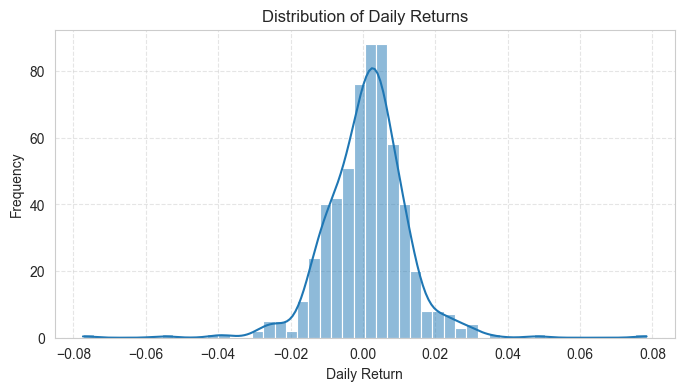

In [18]:
returns = df_clean['Return'].dropna()
plt.figure(figsize=(8,4))
sns.histplot(returns, bins=50, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True, ls='--', alpha=0.5)
plt.show()

Từ biểu đồ ta có thể thấy phân phối lợi suất của cổ phiếu ở dạng phân phối chuẩn. Từ đó ta có thể thấy:
1. Tâm lý thị trường tương đối ổn định.
3. Đường KDE trơn màu xanh cho thấy phân phối này gần với **phân phối hình chuông**, nhưng có độ nhọn cao.

### 4.2. Tính volatility

In [19]:
# Tính volativity theo thángx   
df_clean['YearMonth'] = df_clean['Date'].dt.to_period('M')
vol_monthly = (df_clean.groupby('YearMonth')['Return'].std().reset_index().rename(columns= {'Return' : 'Volatility'}))

vol_monthly['YearMonth'] = vol_monthly['YearMonth'].dt.to_timestamp()

C:\Users\admin\AppData\Local\Temp\ipykernel_19040\2990209285.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_clean['YearMonth'] = df_clean['Date'].dt.to_period('M')


#### *Biểu đồ volatility*

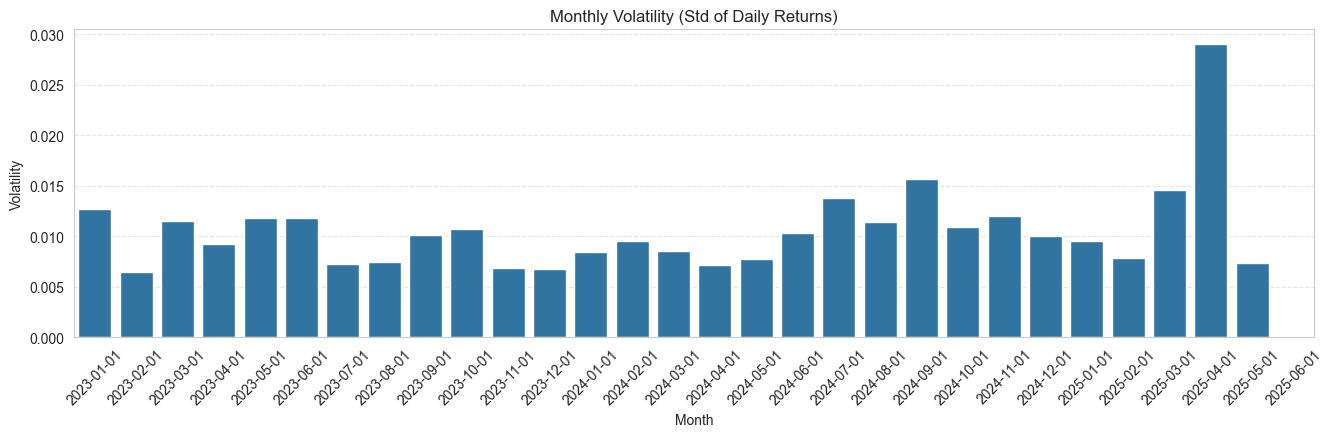

In [20]:
plt.figure(figsize=(16,4))
sns.barplot(data=vol_monthly, x='YearMonth', y='Volatility')
plt.xticks(rotation=45)
plt.title('Monthly Volatility (Std of Daily Returns)')
plt.xlabel('Month')
plt.ylabel('Volatility')
plt.grid(axis='y', ls='--', alpha=0.5)
plt.show()

### 4.3 Phân tích tương quan giá đóng và các chỉ số

In [21]:
# Chọn cột và drop NaN(Do chỉ số NaN ở đầu)
cols = ['Close','SMA20','EMA20','RSI14']
df_corr = df_clean[cols].dropna()

# Tính ma trận tương quan
corr_matrix = df_corr.corr()
corr_matrix

,Close,SMA20,EMA20,RSI14
Close,1.000000,0.983844,0.988774,0.258258
SMA20,0.983844,1.000000,0.999045,0.100250
EMA20,0.988774,0.999045,1.000000,0.123783
RSI14,0.258258,0.100250,0.123783,1.000000


#### *Heat map ma trận tương quan*

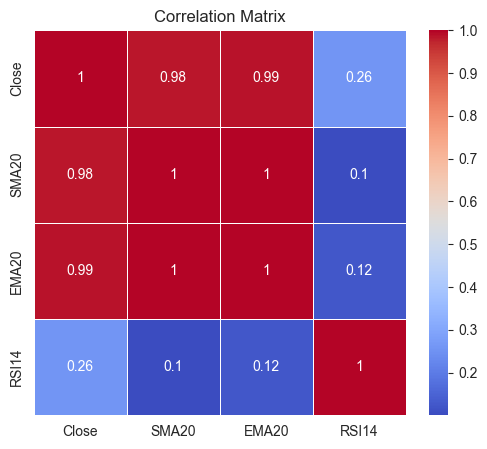

In [22]:
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot= True, cmap= 'coolwarm',linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Heatmap hiển thị trực quan:

- Corr(Close, SMA20) và Corr(Close, EMA20) rất cao (gần 1) do chúng cùng thể hiện mức giá Close.

- Corr(Close, RSI14) thấp hơn do RSI đo dao động của thị trường, không đo giá tuyệt đối.

## 5. Diễn giải & Kết luận

### 5.1. Xu hướng chính
- Trong giai đoạn **01/01/2023 – 14/06/2025**, giá cổ phiếu **V (Visa)** đã **tăng** từ khoảng **229$** (ngày đầu) lên **353$** (ngày cuối), tương ứng tổng lợi suất khoảng **154 %**.
- Đường **SMA20** và **EMA20** phần lớn nằm dưới giá đóng, cho thấy xu hướng **tăng** chung.
- Ví dụ: khi giá cắt lên SMA20 vào khoảng tháng **11/2023**, sau đó tiếp tục đi lên → xác nhận tín hiệu tăng.

### 5.2.Giai đoạn biến động cao
- Tháng **04/2025** có độ biến động (volatility) lớn nhất, khoảng **3%** (độ lệch chuẩn của daily return).  
- Nguyên nhân khả thi:
    - Bất ngờ tích cực về kết quả kinh doanh Q2, với chỉ số tài chính vượt kỳ vọng.
    - Chương trình mua lại cổ phiếu quy mô, tác động mạnh lên cung cầu trên thị trường.
    - Source: 
        - https://www.investors.com/research/investing-action-plan/stock-market-trade-war-tesla-google-boeing-earnings/
        - https://www.reuters.com/business/finance/visa-quarterly-profit-rises-strong-card-spending-volumes-2025-04-29/
- Phần lớn các tháng đều có volatility ổn định dưới **1% - 1.5%**, thị trường tương đối ổn định, ít dao động lớn.

### 5.3. Đề xuất khuyến nghị đầu tư cơ bản
- **Mua (Entry) khi**:  
  1. Giá cắt lên EMA20 kèm volume tăng đột biến.  
  2. RSI đang ở vùng **40–50** (không quá mua, vẫn có dư địa tăng).  
  3. Giá chạm vùng hỗ trợ gần SMA50.

- **Bán (Exit) khi**:  
  1. RSI vượt **70** và giá chững lại hoặc hình thành nến đảo chiều.  
  2. Giá cắt xuống SMA20 → cảnh báo xu hướng tăng ngắn hạn suy yếu.  
  3. Volatility đột biến cao , có thể do tin bất ngờ.

- **Giữ (Hold) khi**:  
  - Giá nằm giữa EMA20 và SMA50, RSI dao động trong **45–55**, volatility thấp → thị trường sideway.

---
> **Tóm lại**, trong năm vừa qua, cổ phiếu V cho tín hiệu xu hướng **tăng tổng thể**, với các giai đoạn biến động đỉnh điểm vào tháng **04/2025**. SMA/EMA giúp xác nhận trend, RSI cho điểm overbought/oversold, và volatility cho biết rủi ro dao động. Kết hợp các chỉ số này, nhà đầu tư có thể **mua** khi giá cắt lên EMA20 + RSI < 50, và **bán** khi RSI > 70 hoặc giá xuyên SMA20.
